In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import numpy as np
import missingno as msno

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print('pandas version :', pd.__version__, '\n')
print('numpy version :', np.__version__, '\n')
print('missingno version :', msno.__version__, '\n')
print('matplotlib version :', matplotlib.__version__, '\n')
print('seaborn version :', sns.__version__)

pandas version : 1.2.4 

numpy version : 1.19.5 

missingno version : 0.5.0 

matplotlib version : 3.3.4 

seaborn version : 0.11.2


In [4]:
# On charge nos deux jeux de données
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')

On va commencer par faire un tri de nos jeux de données afin de savoir lesquels nous allons garder.

## Customers

In [5]:
# On regarde les valeurs manquantes
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

En ce qui concerne les identifiants clients, seul le "*customer_unique_id*" nous intéresse, on garde "*customer_id*" pour pouvoir joindre nos jeux de données dans un second temps.

S'il y a trop de zipcode, de villes ou d'Etats, nous supprimons les colonnes.

In [6]:
cols = ['customer_zip_code_prefix', 'customer_city', 'customer_state']

for col in cols:
    print(f'{col} :', customers[col].nunique(), '\n')

customer_zip_code_prefix : 14994 

customer_city : 4119 

customer_state : 27 



In [7]:
customers.drop(columns=['customer_zip_code_prefix', 'customer_city',
                        'customer_state'], inplace=True)

Au final, nous n'allons garder que le "*customer_id*" et le "*customer_unique_id*".

## Geolocation

In [8]:
# On regarde les valeurs manquantes
geolocation.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [9]:
geolocation.head(3)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


De la même manière que précédemment, on va regarder le nombre de zipcodes, villes et Etats pour savoir si on garde ou non.

In [10]:
cols = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']

for col in cols:
    print(f'{col} :', geolocation[col].nunique(), '\n')

geolocation_zip_code_prefix : 19015 

geolocation_city : 8011 

geolocation_state : 27 



Au final, nous n'allons pas utiliser ce jeu de données.

## Order_items

In [11]:
# On regarde les valeurs manquantes
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [12]:
order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


On supprime la date d'envoi des commandes et les identifiants des produits et vendeurs.

In [13]:
order_items.drop(columns=['product_id', 'shipping_limit_date',
                          'seller_id'], inplace=True)

## Order_payments

In [14]:
# On regarde les valeurs manquantes
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [15]:
order_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


Nous allons uniquement supprimer le type de moyen de paiement utilisé.

In [16]:
order_payments.drop(columns=['payment_type'],
                    inplace=True)

## Order_reviews

In [17]:
# On regarde les valeurs manquantes
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Certaines commandes peuvent avoir plusieurs notes, on va garder les notes les plus récentes.

In [18]:
# On veut juste savoir combiens de commandes ont plusieurs notes
doublons = order_reviews[order_reviews['order_id'].duplicated()]

In [19]:
# On transforme nos dates dans le bon format
order_reviews['review_answer_timestamp'] = pd.to_datetime(
    order_reviews['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S')

# On trie pour avoir nos notes les plus récentes en premières
order_reviews.sort_values('review_answer_timestamp',
                          ascending=False, inplace=True)

# On note combien on a de lignes
nb_row = order_reviews.shape[0]

In [20]:
# On supprime nos doublons
order_reviews.drop_duplicates(subset=['order_id'], inplace=True)

# On note combien on a de lignes
nb_row_drop = order_reviews.shape[0]

In [21]:
# On vérifie
print('Nombre de doublons :', doublons.shape[0], '\n')
print('Nombre de lignes supprimées :', nb_row - nb_row_drop)

Nombre de doublons : 551 

Nombre de lignes supprimées : 551


Seul le score donné à la commande nous intéresse.

In [22]:
order_reviews.drop(columns=['review_id', 'review_comment_title',
                            'review_comment_message', 'review_creation_date',
                            'review_answer_timestamp'], inplace=True)

## Order

In [23]:
# On regarde les valeurs manquantes
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Nous n'avons besoin que de savoir quand a eu lieu le dernier achat (on garde "*order_purchase_timestamp*").

In [24]:
orders.drop(columns=['order_status', 'order_approved_at',
                     'order_delivered_carrier_date',
                     'order_delivered_customer_date',
                     'order_estimated_delivery_date'], inplace=True)

## Products

In [25]:
# On regarde les valeurs manquantes
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Les informations relatives aux produits (taille, photo, etc.) ne nous intéresse pas pour segmenter les clients. On va regarder à quoi correspond les différentes catégories de produits.

In [26]:
# On supprime directement ces colonnes
products.drop(columns=['product_name_lenght', 'product_description_lenght',
                       'product_photos_qty', 'product_weight_g',
                       'product_length_cm', 'product_height_cm',
                       'product_width_cm'], inplace=True)

In [27]:
# On regarde les catégories
print(products['product_category_name'].unique(), '\n')
print('Nombre de catégories :', products['product_category_name'].nunique())

['perfumaria' 'artes' 'esporte_lazer' 'bebes' 'utilidades_domesticas'
 'instrumentos_musicais' 'cool_stuff' 'moveis_decoracao'
 'eletrodomesticos' 'brinquedos' 'cama_mesa_banho'
 'construcao_ferramentas_seguranca' 'informatica_acessorios'
 'beleza_saude' 'malas_acessorios' 'ferramentas_jardim'
 'moveis_escritorio' 'automotivo' 'eletronicos' 'fashion_calcados'
 'telefonia' 'papelaria' 'fashion_bolsas_e_acessorios' 'pcs'
 'casa_construcao' 'relogios_presentes'
 'construcao_ferramentas_construcao' 'pet_shop' 'eletroportateis'
 'agro_industria_e_comercio' nan 'moveis_sala' 'sinalizacao_e_seguranca'
 'climatizacao' 'consoles_games' 'livros_interesse_geral'
 'construcao_ferramentas_ferramentas' 'fashion_underwear_e_moda_praia'
 'fashion_roupa_masculina'
 'moveis_cozinha_area_de_servico_jantar_e_jardim'
 'industria_comercio_e_negocios' 'telefonia_fixa'
 'construcao_ferramentas_iluminacao' 'livros_tecnicos'
 'eletrodomesticos_2' 'artigos_de_festas' 'bebidas' 'market_place'
 'la_cuisine' 'const

Il y a beaucoup trop de catégories pour que cela soit utile à une équipe marketing, on supprime la colonne. Il ne resterait que la colonne "*product_id*" que nous n'allons pas utiliser. Au final, il s'avère que nous n'allons pas du tout utiliser ce jeu de données.

## Sellers

In [28]:
# On regarde les valeurs manquantes
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Nous n'avons pas besoin des informations relatives aux vendeurs pour segmenter nos clients. Nous n'allons pas utiliser ce jeu de données non plus.

# Fusion et nettoyage des données

In [29]:
# On fusionne nos jeux de données
df = (orders.merge(customers, on='customer_id', how='left')
      .merge(order_reviews, on='order_id', how='left')
      .merge(order_payments, on='order_id', how='left')
      .merge(order_items, on='order_id', how='left'))

In [30]:
# Format du jeu de données
df.shape

(118434, 11)

In [31]:
# On vérifie la présence de doublon
df.duplicated().sum()

0

In [32]:
# On peut maintenant supprimer "customer_id"
df.drop(columns=['customer_id'], inplace=True)

In [33]:
# Regardons nos valeurs manquantes
df.isnull().sum()

order_id                      0
order_purchase_timestamp      0
customer_unique_id            0
review_score                997
payment_sequential            3
payment_installments          3
payment_value                 3
order_item_id               830
price                       830
freight_value               830
dtype: int64

<AxesSubplot:>

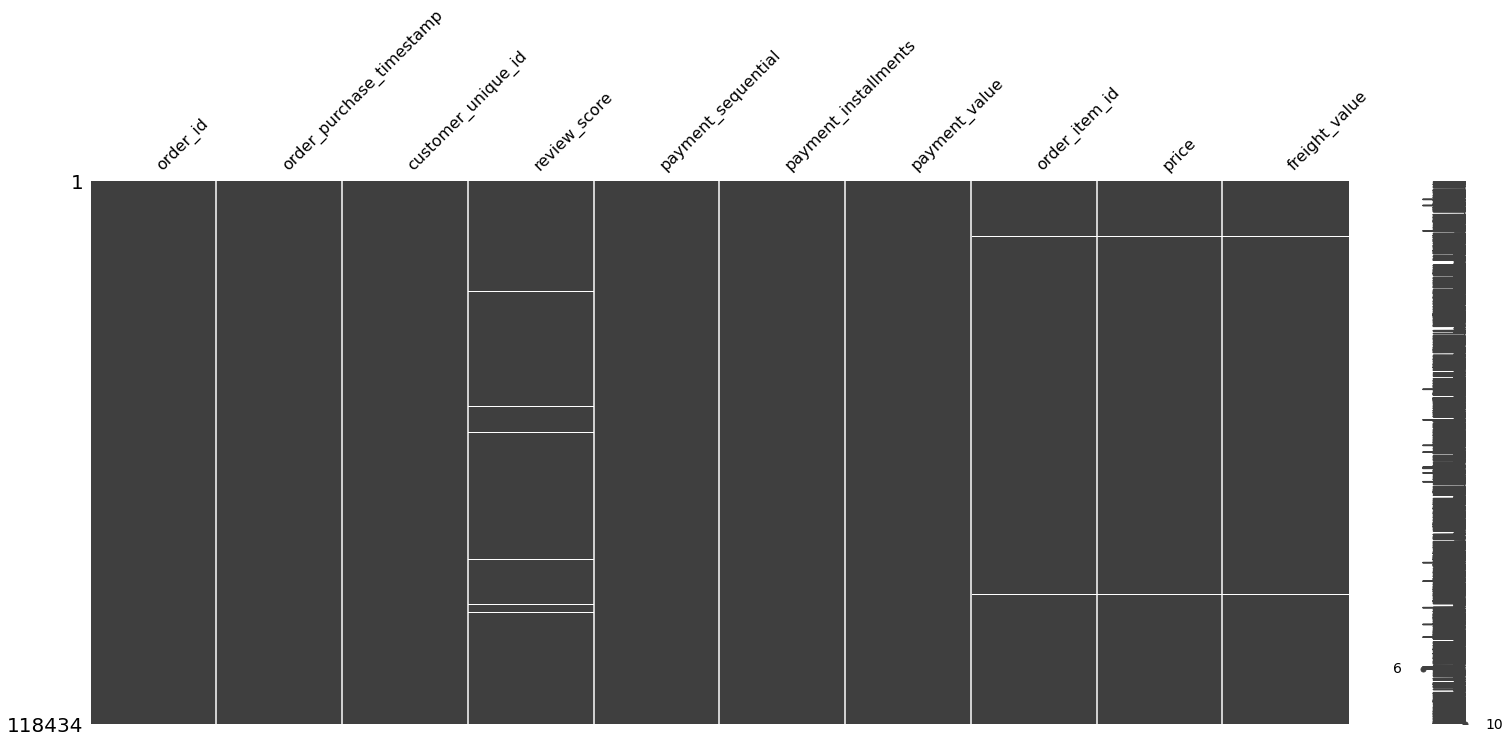

In [34]:
# Regardons visuellement les valeurs manquantes
msno.matrix(df)

Les valeurs manquantes de notre colonne "*review_score*" correspondent à des commandes qui n'ont pas eu de note. On remplace les commandes sans notes par la note moyenne de la colonne. On garde la note sous la forme de nombre entier.

In [35]:
# On calcule en amont la note moyenne
note_moy = df['review_score'].mean()

# Et on remplace
df['review_score'].fillna(round(note_moy), inplace=True)

# On affice la note moyenne pour information
print('La note moyenne est :', note_moy)

La note moyenne est : 4.016127796180079


On s'intéresse à nos dernières valeurs manquantes.

Si une commande a eu 3 produits par exemple, nous allons nous retrouver avec 3 lignes différentes. C'est la même chose pour le nombre de moyen de paiements et le nombre de paiements effectués. On va juste garder le nombre maximale de produits, de moyens de paiements et de paiements effectués.

In [36]:
# Regardons quelles sont les valeurs de la colonne "order_item_id"
df['order_item_id'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6., nan,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21.])

In [37]:
# Regardons quelles sont les valeurs de la colonne "payment_installments"
df['payment_installments'].unique()

array([ 1.,  3.,  6., 10.,  4.,  2.,  8.,  9.,  7.,  5., 13., 12., 15.,
       14., 21., 18., 24., 17., 11., 20., 23., 16., nan, 22.,  0.])

In [38]:
# Regardons quelles sont les valeurs de la colonne "payment_sequential"
df['payment_sequential'].unique()

array([ 1.,  3.,  2.,  4.,  8.,  5.,  7.,  9.,  6., 14., 17., 22., 11.,
       16., 13., 18., 12., 19., 21., 20., 10., 15., 27., 25., 29., 28.,
       26., 23., 24., nan])

Pour les colonnes "*order_item_id*", "*payment_installments*" et "*payment_sequential*", on va donc remplacer toutes les valeurs de chaque commande par son maximum. On peut ensuite supprimer les doublons.

In [39]:
# On garde le maximum de chaque commande pour nos 3 colonnes
df['order_item_id'] = df.groupby('order_id')['order_item_id'].transform('max')

df['payment_sequential'] = (df.groupby('order_id')['payment_sequential']
                            .transform('max'))

df['payment_installments'] = (df.groupby('order_id')['payment_installments']
                              .transform('max'))
# On supprime les doublons
df.drop_duplicates(inplace=True)

In [40]:
# On calcule le montant total de chaque commande
df['order_total_cost'] = (df.groupby('order_id')['payment_value']
                          .transform('sum'))

In [41]:
# Regardons les premières lignes
df.head()

,order_id,order_purchase_timestamp,customer_unique_id,review_score,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,order_total_cost
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,4.0,3.0,1.0,18.12,1.0,29.99,8.72,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,4.0,3.0,1.0,2.00,1.0,29.99,8.72,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,4.0,3.0,1.0,18.59,1.0,29.99,8.72,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,4.0,1.0,1.0,141.46,1.0,118.70,22.76,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,5.0,1.0,3.0,179.12,1.0,159.90,19.22,179.12


On peut maintenant supprimer un certain nombre de colonnes : "*payment_sequential*", "*product_id*", "*price*", "*freight_value*" et "*payment_value*".

In [42]:
df.drop(columns=['payment_sequential', 'price',
                 'freight_value', 'payment_value'], inplace=True)

In [43]:
# On regarde si on a encore des doublons
df.duplicated().sum()

6880

In [44]:
# On supprime les derniers doublons
df = df.drop_duplicates()

In [45]:
# On regarde les dernières valeurs manquantes
print(df.isnull().sum(), '\n')
print(df.isnull().mean())

order_id                      0
order_purchase_timestamp      0
customer_unique_id            0
review_score                  0
payment_installments          1
order_item_id               775
order_total_cost              0
dtype: int64 

order_id                    0.000000
order_purchase_timestamp    0.000000
customer_unique_id          0.000000
review_score                0.000000
payment_installments        0.000010
order_item_id               0.007794
order_total_cost            0.000000
dtype: float64


Nous allons supprimer les dernières valeurs manquantes plutôt que de remplacer par d'autres valeurs.

In [46]:
# On supprime les dernières valeurs manquantes
df.dropna(subset=['order_item_id', 'payment_installments'], inplace=True)

In [47]:
# Taille de notre jeu de données
df.shape

(98665, 7)

Nous allons maintenant changer le type de certaines de nos colonnes

In [48]:
# On vérifie le type de nos colonnes
df.dtypes

order_id                     object
order_purchase_timestamp     object
customer_unique_id           object
review_score                float64
payment_installments        float64
order_item_id               float64
order_total_cost            float64
dtype: object

In [49]:
# On transforme quelques colonnes en entiers pour mieux refléter le contenu
for col in ['review_score', 'payment_installments', 'order_item_id']:
    df[col] = df[col].astype(int)

In [50]:
# On transforme notre colonne de date en datetime
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [51]:
# On vérifie
df.head(3)

,order_id,order_purchase_timestamp,customer_unique_id,review_score,payment_installments,order_item_id,order_total_cost
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,4,1,1,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,4,1,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,5,3,1,179.12


In [52]:
# On enlève les heures - minutes - secondes, on ne garde que la date
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.date

Pour information, on va regarder la date de la première et de la dernière commande ainsi que le temps entre les deux.

In [53]:
# Date de la dernière commande du jeu de données
jour_max = df['order_purchase_timestamp'].max()
print('Date de la dernière commande du jeu de données :', jour_max)

# Date de la première commande du jeu de données
jour_min = df['order_purchase_timestamp'].min()
print('Date de la première commande du jeu de données :', jour_min)

# Nombre de jour au total
nb_jours = (jour_max - jour_min).days
print('Nombre de jours :', nb_jours)

Date de la dernière commande du jeu de données : 2018-09-03
Date de la première commande du jeu de données : 2016-09-04
Nombre de jours : 729


On crée une colonne qui va calculer la différence entre la durée entre la commande la plus récente (du 03/09/2018) et la commande de chacune de nos lignes.

In [54]:
# Temps entre la commande du client et la dernière date du jeu de données
df['time_delta'] = (df['order_purchase_timestamp'].max()
                    - df['order_purchase_timestamp'])

In [55]:
df.head(3)

,order_id,order_purchase_timestamp,customer_unique_id,review_score,payment_installments,order_item_id,order_total_cost,time_delta
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02,7c396fd4830fd04220f754e42b4e5bff,4,1,1,38.71,336 days
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24,af07308b275d755c9edb36a90c618231,4,1,1,141.46,41 days
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08,3a653a41f6f9fc3d2a113cf8398680e8,5,3,1,179.12,26 days


In [56]:
# On transforme "time_delta" pour n'avoir que les jours en nombres entiers
df['time_delta'] = df['time_delta'].dt.days

In [57]:
# On vérifie le typage de nos colonnes
df.dtypes

order_id                     object
order_purchase_timestamp     object
customer_unique_id           object
review_score                  int32
payment_installments          int32
order_item_id                 int32
order_total_cost            float64
time_delta                    int64
dtype: object

On vérifie les valeurs de nos variables.

In [58]:
df.describe()

,review_score,payment_installments,order_item_id,order_total_cost,time_delta
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,4.103897,2.931870,1.141712,168.470796,245.711276
std,1.326601,2.714891,0.538423,247.568345,153.386346
min,1.000000,0.000000,1.000000,6.150000,0.000000
25%,4.000000,1.000000,1.000000,61.940000,122.000000
50%,5.000000,2.000000,1.000000,106.010000,227.000000
75%,5.000000,4.000000,1.000000,181.160000,356.000000
max,5.000000,24.000000,21.000000,13664.080000,729.000000


In [59]:
# On ne peut pas avoir 0 paiements
# On regarde combien de valeurs sont à 0
df['payment_installments'].value_counts()

1     47823
2     12291
3     10371
4      7022
10     5261
5      5188
8      4237
6      3887
7      1611
9       635
12      131
15       74
18       27
11       22
24       18
20       17
13       16
14       15
17        7
16        5
21        3
0         2
22        1
23        1
Name: payment_installments, dtype: int64

In [60]:
# On va remplacer nos deux lignes avec des "0" par des "1"
for row in df.index:

    if df.loc[row, 'payment_installments'] == 0:
        df.loc[row, 'payment_installments'] = 1

On va sauvegarder ce jeu de données tel quel afin de pouvoir ensuite étudier uniquement certaines périodes temporelles.

In [61]:
# On sauvegarde notre jeu de données au format .csv
df_csv = df.to_csv('P5_01_frequence.csv')

# Agrégation et analyse de nos variables

## Agrégation

In [62]:
# On crée une copie
df_bis = df.copy()

On va agréger nos colonnes pour avoir chaque commande en fonction de nos clients. 

In [63]:
df_bis = (df_bis.groupby('customer_unique_id').agg(
    nb_commandes=('order_id', 'count'), score_moy=('review_score', 'mean'),
    nb_paiements=('payment_installments', 'mean'),
    nb_produits=('order_item_id', 'mean'),
    recence=('time_delta', 'min'),
    montant_total=('order_total_cost', 'sum')))

On transforme en nombres entiers les colonnes où nous avons calculé des moyennes.

In [64]:
for col in ['score_moy', 'nb_paiements', 'nb_produits']:
    df_bis[col] = df_bis[col].astype(int)

Il nous reste à ajouter la fréquence d'achat de chacun des clients sur la période étudiée.

In [65]:
df_bis['frequence_achat'] = round(df_bis['nb_commandes'] / nb_jours, 4)

In [66]:
# Pour information :
df_bis['frequence_achat'].unique()

array([0.0014, 0.0027, 0.0041, 0.0055, 0.0082, 0.0096, 0.0069, 0.0123,
       0.0219])

## Analyse des variables

In [67]:
# Analyse univariée des variables que l'on souhaite
def univariee(col, data):
    """
    Prend une variable d'un dataframe et retourne les mesures
    de tendance centrale (moyenne, médiane) et les mesures
    de dispersion (variance, écart-type) de la variable choisie.
    Pour une visualisation graphique, retourne l'histogramme
    de la variable choisie.
            Parameters:
                col (object): variable que l'on souhaite étudier
                data : dataframe à utiliser
    """
    # On vérifie que la variable en entrée est bien numérique
    if ((data[col].dtype == float) |
            (data[col].dtype == np.int64) | (data[col].dtype == np.int32)):

        # Mesures de tendances centrales et de dispersion de la variable
        print(col)
        print('moyenne :', round(data[col].mean(), 2))
        print('médiane :', round(data[col].median(), 2))
        print('variance :', round(data[col].var(), 2))
        print('écart-type :', round(data[col].std(), 2))

        # Histrogramme de la distribution de la variable
        sns.set_context('notebook', font_scale=1.25)
        plt.style.use('seaborn-darkgrid')
        plt.figure(figsize=(8, 8))
        plt.hist(x=data[col].values, bins=50, align='left',
                 color='#4d7cab', edgecolor='black', linewidth=1.1)
        plt.title(f'Distribution de la variable : {col}')
        plt.show()

    else:
        print(f"{col} n'est pas une variable quantitatives.", '\n')

In [68]:
# On vérifie les colonnes
df_bis.columns

Index(['nb_commandes', 'score_moy', 'nb_paiements', 'nb_produits', 'recence',
       'montant_total', 'frequence_achat'],
      dtype='object')

nb_commandes
moyenne : 1.03
médiane : 1.0
variance : 0.04
écart-type : 0.21


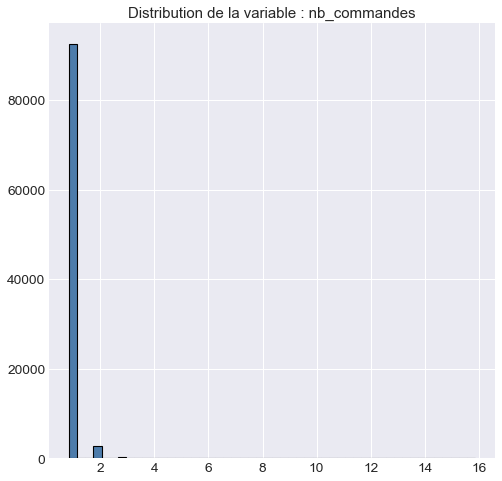

score_moy
moyenne : 4.1
médiane : 5.0
variance : 1.75
écart-type : 1.32


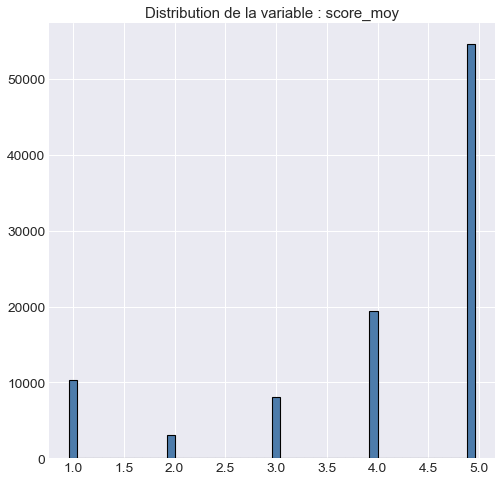

nb_paiements
moyenne : 2.91
médiane : 2.0
variance : 7.24
écart-type : 2.69


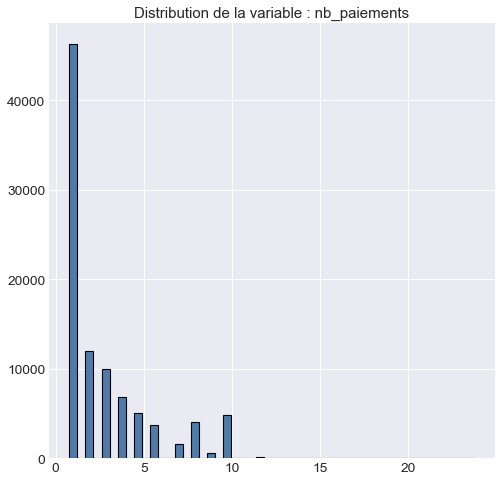

nb_produits
moyenne : 1.14
médiane : 1.0
variance : 0.28
écart-type : 0.52


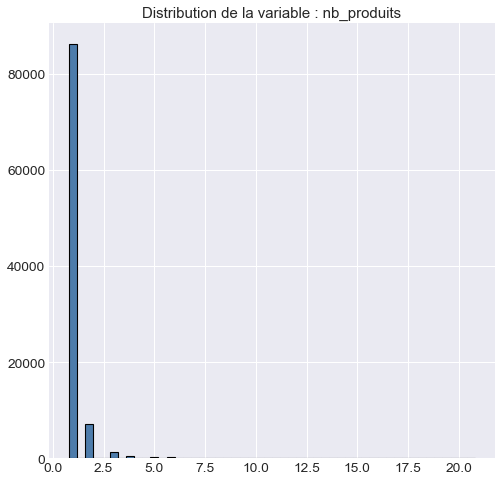

recence
moyenne : 243.5
médiane : 224.0
variance : 23456.13
écart-type : 153.15


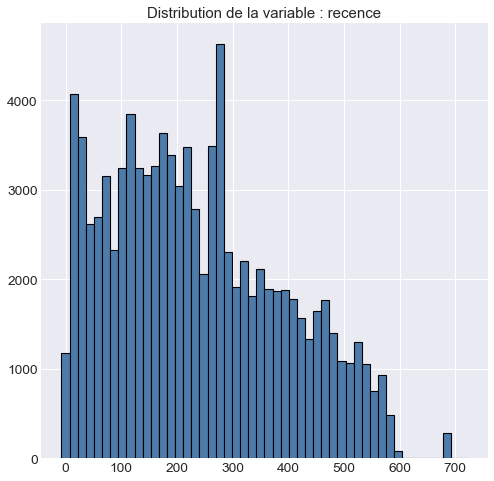

montant_total
moyenne : 174.2
médiane : 108.6
variance : 65657.34
écart-type : 256.24


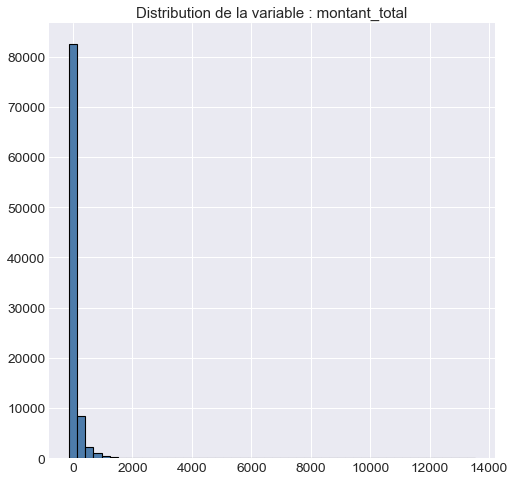

frequence_achat
moyenne : 0.0
médiane : 0.0
variance : 0.0
écart-type : 0.0


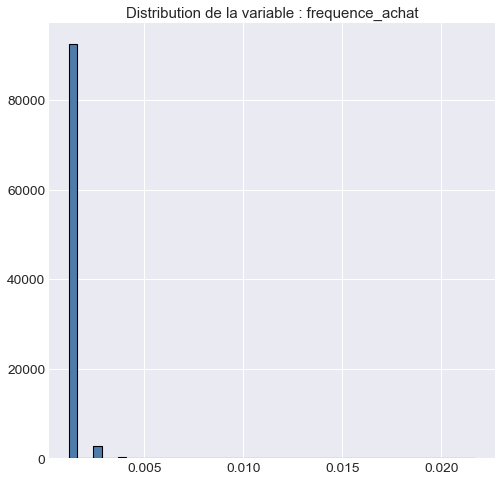

In [69]:
# On regarde nos variables
for col in df_bis.columns:
    univariee(col, df_bis)

Les colonnes "*nb_commandes*", "*nb_paiments*", "*nb_produits*", "*montant_total*" et "*frequence_achat*" devront être passées au log pour transformer la distribution qui, pour l'instant, est très concentrée sur des petites valeurs.